# GNN for Link + Vote Prediction

This notebook trains a **Graph Neural Network (GraphSAGE)** to predict, for a pair *(voter u, candidate t)*:

- **Link existence**: will *u* vote on *t*? (`NoVote` vs `Voted`)
- **Vote polarity** (if voted): `Oppose`, `Neutral`, or `Support`

We output a 4-class prediction, but train hierarchically with two heads: link existence and vote polarity.

Key implementation choices:
- **No leakage**: message passing uses only **training positive edges**.
- **Mini-batch training** with **LinkNeighborLoader**: each batch samples a subgraph around the queried links.
- **Negative sampling**: we create `NoVote` examples by sampling users who did **not** vote for the same candidate.

## Setup

In [4]:
# Import standard libraries
import sys, random
from pathlib import Path
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Data handling
import pandas as pd
# Computations
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import LinkNeighborLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from dataset import WikiRfAPreprocessor, CandidateCentricSampler, train_val_test_split_by_date
from utility import analyze_split_statistics
from training import eval_hierarchical, train_hierarchical

## Data loading and filtering

Load and parse the wiki-RfA dataset from the .txt.gz file into (SRC, TGT, VOT, DAT) tuples.

Invalid samples are filtered out:

- empty date
- incorrect date
- self votes

In [5]:
preprocessed_RfA = WikiRfAPreprocessor("dataset/wiki-RfA.txt.gz")
preprocessed_RfA.load(verbose=True)

Loading dataset from dataset/wiki-RfA.txt.gz...
Raw line 0: SRC:Steel1943
Raw line 1: TGT:BDD
Raw line 2: VOT:1
Raw line 3: RES:1
Raw line 4: YEA:2013
Raw line 5: DAT:23:13, 19 April 2013
Raw line 6: TXT:'''Support''' as co-nom.
Raw line 7: 
Raw line 8: SRC:Cuchullain
Raw line 9: TGT:BDD

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncycloped

## User encoding

Encode Wikipedia usernames into contiguous integer node IDs.

In [6]:
# Encode users as numerical IDs
users = list(set([s[0] for s in preprocessed_RfA.samples] + [s[1] for s in preprocessed_RfA.samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11128
[('Davidcannon', np.int64(2460)), ('Alden Jones', np.int64(402)), ('The Giant Puffin', np.int64(9489)), ('Mareino', np.int64(6012)), ('Rosicrucian', np.int64(8184)), ('Georgian Jungle', np.int64(3755)), ('Mipadi', np.int64(6397)), ('TeaDrinker', np.int64(9375)), ('Drjmarkov', np.int64(2826)), ('Faizan Al-Badri', np.int64(3294))]


In [7]:
# Dataset build (edge list + label)
X = []
y = []
dates = []

for src, tgt, vot, dat in preprocessed_RfA.samples:
    X.append([user_map[src], user_map[tgt]])
    y.append(vot)
    dates.append(dat)
        
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)
dates = np.array(dates)

# labels for positives: {-1,0,1} -> {1,2,3}
y_pos = y + 2
print("Positive edges:", X.size(0))

Positive edges: 188816


## Train - Validation - Test split

This function divide the whole dataset in three parts based on the date. The outputs are ordered by date.

Training set shape: torch.Size([180838, 2]) between dates 20030816 and 20120603
Validation set shape: torch.Size([4139, 2]) between dates 20120609 and 20121204
Test set shape: torch.Size([3839, 2]) between dates 20121212 and 20130605

===================== DATASET SPLITTING ANALYSIS =====================

[1] Topology & Density (Graph Connectivity)
        Edges  Nodes Avg Degree
Split                          
Train  172949  10707      16.15
Val      4122    827       4.98
Test     3837    831       4.62

[2] User Overlap & Cold Start Diagnostics (Inductive vs Transductive)


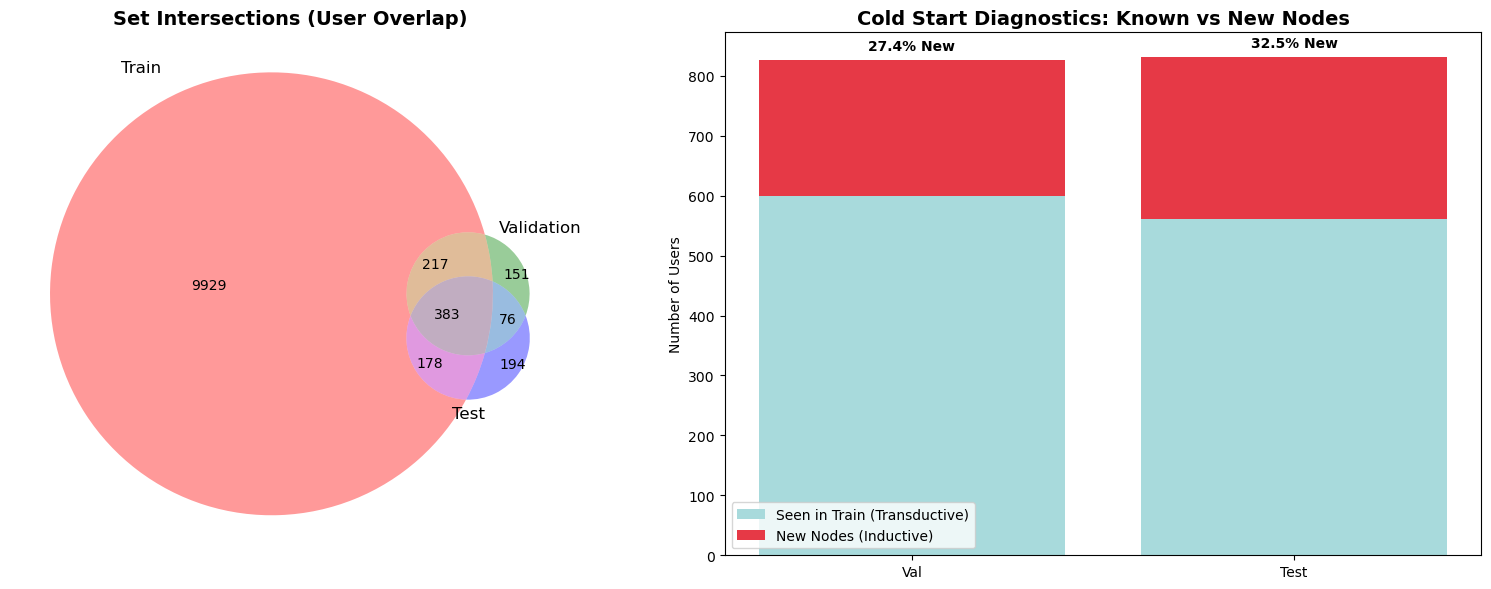


[3] Edge Duplicates Analysis
Found 25 duplicate edges between Train-Val
Found 19 duplicate edges between Train-Test
Found 83 duplicate edges between Val-Test

[4] Class Distribution Analysis (Vote Polarity)


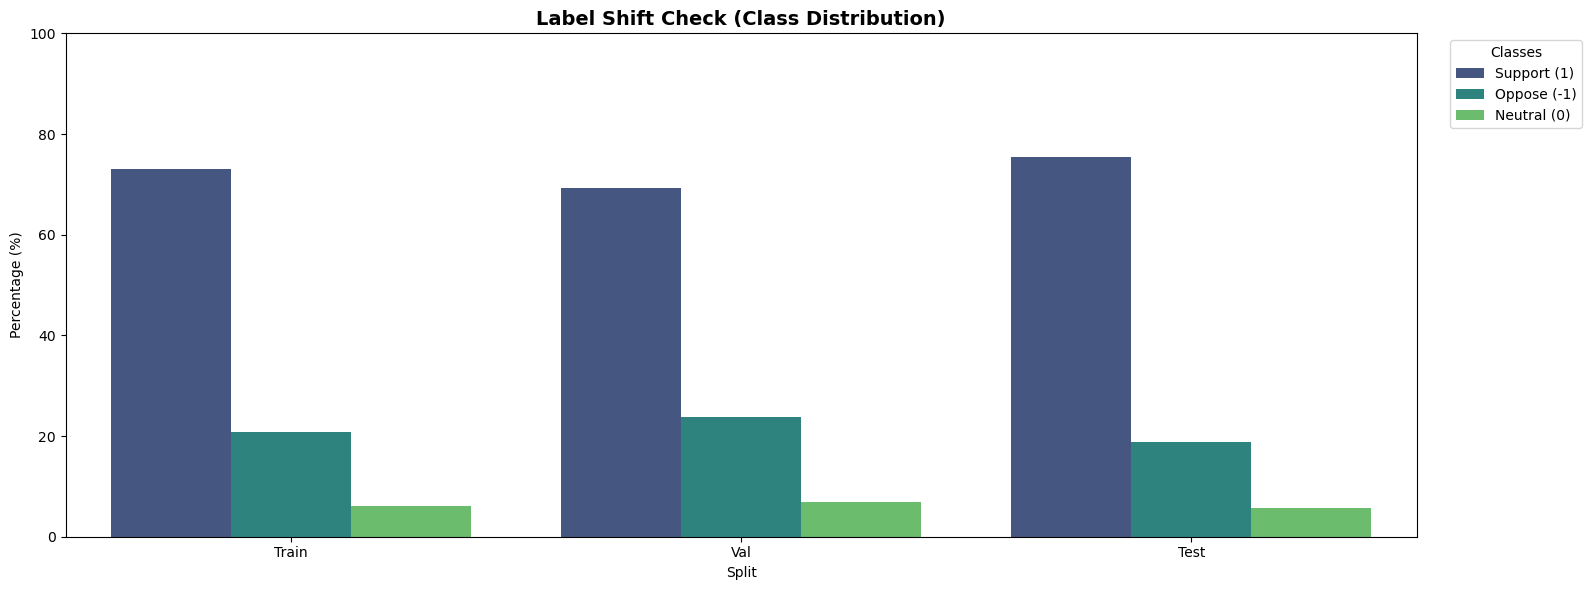

In [8]:
(X_tr_pos, y_tr_pos, dates_tr), (X_val_pos, y_val_pos, dates_val), (X_test_pos, y_test_pos, dates_test) = train_val_test_split_by_date(X, y_pos, dates)

# Splits summary
print(f"Training set shape: {X_tr_pos.shape} between dates {dates_tr.min()} and {dates_tr.max()}")
print(f"Validation set shape: {X_val_pos.shape} between dates {dates_val.min()} and {dates_val.max()}")
print(f"Test set shape: {X_test_pos.shape} between dates {dates_test.min()} and {dates_test.max()}")

analyze_split_statistics(X_tr_pos, y_tr_pos, X_val_pos, y_val_pos, X_test_pos, y_test_pos)

## Data structure creation

The structure will contain only edges in the training set to avoid data leakage.

Features are initialized using knowledge gained from the training set containing 

- in degree (votes received)
- out degree (votes given)
- Tenure (Anzianità) ----> $T_{now} - T_{first\ vote}$
- Recency (Recenza) ----> $T_{now} - T_{last\ vote}$
- Activity Span ----> $T_{last\ vote} - T_{first\ vote}$
- Frequenza di voto ----> # votes / Activity span

In [9]:
def extract_node_features(edge_index: torch.Tensor, edge_dates: np.ndarray, num_nodes: int) -> torch.Tensor:
    """
    Compute structural and temporal features for nodes in a dynamic graph.
    
    Args:
        edge_index (torch.Tensor): [2, E] Source (Voter) -> Target (Candidate)
        edge_dates (np.ndarray): [E] Dates in YYYYMMDD format (int)
        num_nodes (int): Total number of nodes in the graph
    Returns:
        torch.Tensor: [num_nodes, 6] Normalized feature matrix
    """
    
    # Conversion: YYYYMMDD to Timestamp Linear (days)
    dates_pd = pd.to_datetime(edge_dates, format='%Y%m%d')
    ref_date = pd.to_datetime(edge_dates.max(), format='%Y%m%d')
    
    df = pd.DataFrame({
        'src': edge_index[0].cpu().numpy(),
        'tgt': edge_index[1].cpu().numpy(),
        'date': dates_pd
    })
    
    # Initialize features to 0 ----> [In-Deg, Out-Deg, Tenure, Recency, Span, Freq]
    features = np.zeros((num_nodes, 6), dtype=np.float32)
    
    # ---------------------------------------------------------
    # 1. Structural Features (Degrees)
    # ---------------------------------------------------------
    in_degree = df.groupby('tgt').size()
    out_degree = df.groupby('src').size()
    
    features[in_degree.index, 0] = in_degree.values  # In-Degree (Votes Received)
    features[out_degree.index, 1] = out_degree.values # Out-Degree (Votes Given)

    # ---------------------------------------------------------
    # 2. Temporal Features (Tenure, Recency, Span)
    # ---------------------------------------------------------
    # Group by SRC (Voter) to calculate T_first_vote and T_last_vote
    grp_src = df.groupby('src')['date'].agg(['min', 'max'])
    
    voter_indices = grp_src.index.values
    t_first = grp_src['min']
    t_last = grp_src['max']
    
    # (.dt.days converts Timedelta to int)
    features[voter_indices, 2] = (ref_date - t_first).dt.days.values   # Tenure (Anzianità): T_now - T_first
    features[voter_indices, 3] = (ref_date - t_last).dt.days.values    # Recency (Recenza): T_now - T_last
    features[voter_indices, 4] = (t_last - t_first).dt.days.values     # Activity Span: T_last - T_first
    
    # ---------------------------------------------------------
    # 3. Derived Features (Frequency)
    # ---------------------------------------------------------
    # Add 1 day to span to avoid division by zero     
    safe_span = features[voter_indices, 4] + 1.0 
    votes_given = features[voter_indices, 1]
    
    features[voter_indices, 5] = votes_given / safe_span

    # ---------------------------------------------------------
    # 4. Logarithmic Normalization (Critical for Neural Networks)
    # ---------------------------------------------------------   
    return torch.tensor(np.log1p(features), dtype=torch.float)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # oppure 'mps' su Mac
num_users = len(user_map)

# Message-passing graph MUST contain only TRAIN POSITIVE edges (to avoid leakage)
train_edge_index = X_tr_pos.t().contiguous()  # [2, E_train_pos]

# Remove duplicated edges
# train_edge_index, _ = coalesce(train_edge_index, None, num_nodes=num_users)
# duplicated_edges = X_tr_pos.size(0) - train_edge_index.size(1)
# if duplicated_edges > 0:
#     print(f"ATTENTION: there are {duplicated_edges} duplicated edges in the training positive edges which have been merged.")

x_features = extract_node_features(
    edge_index=train_edge_index,
    edge_dates=dates_tr,
    num_nodes=num_users
)

print(f"Training edge index shape: {train_edge_index.shape}")
print(f"Node features shape: {x_features.shape}")

data = Data(x=x_features, edge_index=train_edge_index)

Training edge index shape: torch.Size([2, 180838])
Node features shape: torch.Size([11128, 6])


## Negative sampling

**Metodologia:**
Per ogni arco positivo reale $(u, t)$ nel training set, generiamo $k$ archi negativi $(u', t)$ dove $u'$ è un utente casuale che non ha **mai** votato per il candidato $t$.
La verifica viene effettuata contro una **Global Forbidden Map** che contiene l'unione di tutti gli archi positivi presenti in Train, Validation e Test set.

**Perché questa scelta è superiore al Random Sampling:**
1.  **Candidate-Centric:** Mantenendo fisso il candidato target $t$ e variando solo il votante, preserviamo la distribuzione di popolarità dei candidati (il *degree distribution*). I candidati che ricevono molti voti avranno proporzionalmente più esempi negativi, costringendo il modello a imparare caratteristiche distintive più fini rispetto alla semplice popolarità.
2.  **Eliminazione dei Falsi Negativi (Noise Reduction):** Nel puro random sampling, c'è il rischio di selezionare come "esempio negativo" una coppia $(u, t)$ che appare nel Test set (futuro). Questo insegnerebbe alla rete che l'arco $(u, t)$ non deve esistere, introducendo *label noise* contraddittorio.

**Nota sul Data Leakage:**
L'utilizzo della *Global Forbidden Map* (che include informazioni dal Test set) **non costituisce Data Leakage dannoso**.
* **Non è Leakage:** Non stiamo usando l'informazione futura per predire l'etichetta positiva (non diciamo al modello "questo arco esiste").
* **È Noise Filtering:** Stiamo usando l'informazione futura solo per *escludere* un dato dal training set dei negativi. Garantiamo che i negativi siano **Veri Negativi**, evitando di penalizzare il modello per un arco che, nella realtà storica del dataset, si verificherà successivamente.

In [11]:
neg_ratio = 2

sampler = CandidateCentricSampler([X_tr_pos, X_val_pos, X_test_pos])

# Negatives for each split (no_vote = 0)
X_tr_neg, y_tr_neg = sampler.sample_negatives(X_tr_pos, num_users, ratio=neg_ratio, seed=42)
X_val_neg, y_val_neg = sampler.sample_negatives(X_val_pos, num_users, ratio=neg_ratio, seed=123)
X_test_neg, y_test_neg = sampler.sample_negatives(X_test_pos, num_users, ratio=neg_ratio, seed=999)

# 4-class datasets: 0=no_vote, 1=oppose, 2=neutral, 3=support
X_tr_4 = torch.cat([X_tr_pos,  X_tr_neg],  dim=0)
y_tr_4 = torch.cat([y_tr_pos,  y_tr_neg],  dim=0)

X_val_4 = torch.cat([X_val_pos, X_val_neg], dim=0)
y_val_4 = torch.cat([y_val_pos, y_val_neg], dim=0)

X_test_4 = torch.cat([X_test_pos, X_test_neg], dim=0)
y_test_4 = torch.cat([y_test_pos, y_test_neg], dim=0)

print("Train 4-class size:", X_tr_4.size(0), " (pos:", X_tr_pos.size(0), "neg:", X_tr_neg.size(0), ")")
print("Val 4-class size:", X_val_4.size(0), " (pos:", X_val_pos.size(0), "neg:", X_val_neg.size(0), ")")
print("Test 4-class size:", X_test_4.size(0), " (pos:", X_test_pos.size(0), "neg:", X_test_neg.size(0), ")")

# ---- Class weights (smoothed) ----
# For hierarchical training we use:
# - link weights on {NoVote, Voted}
# - polarity weights on {Oppose, Neutral, Support} (only positives)

# Link labels derived from 4-class labels: 0 -> NoVote, {1,2,3} -> Voted
y_tr_link = (y_tr_4 != 0).long()
link_counts = torch.bincount(y_tr_link, minlength=2).float()
link_base_w = link_counts.sum() / (len(link_counts) * link_counts)
alpha = 0.5
link_weights = link_base_w.pow(alpha).to(device)

# Polarity labels from positives only: {1,2,3} -> {0,1,2}
y_tr_pol = (y_tr_pos - 1).long()
pol_counts = torch.bincount(y_tr_pol, minlength=3).float()
pol_base_w = pol_counts.sum() / (len(pol_counts) * pol_counts)
pol_weights = pol_base_w.pow(alpha).to(device)

print("Train link counts [NoVote, Voted]:", link_counts.tolist())
print("Link weights:", link_weights.tolist())
print("Train polarity counts [Oppose, Neutral, Support]:", pol_counts.tolist())
print("Polarity weights:", pol_weights.tolist())

Train 4-class size: 542514  (pos: 180838 neg: 361676 )
Val 4-class size: 12417  (pos: 4139 neg: 8278 )
Test 4-class size: 11517  (pos: 3839 neg: 7678 )
Train link counts [NoVote, Voted]: [361676.0, 180838.0]
Link weights: [0.8660253882408142, 1.2247449159622192]
Train polarity counts [Oppose, Neutral, Support]: [37558.0, 11136.0, 132144.0]
Polarity weights: [1.266872763633728, 2.3265886306762695, 0.675399124622345]


## Neighbor-sampled loaders

Create LinkNeighborLoader objects to train on mini-batches using sampled subgraphs.

In [12]:
# LinkNeighborLoader
# Message passing happens on data.edge_index (TRAIN POS edges only)
train_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_tr_4.t().contiguous(),
    edge_label=y_tr_4,
    batch_size=2048,
    shuffle=True
)

val_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_val_4.t().contiguous(),
    edge_label=y_val_4,
    batch_size=4096,
    shuffle=False
)

test_loader = LinkNeighborLoader(
    data=data,
    num_neighbors=[100, 50],
    edge_label_index=X_test_4.t().contiguous(),
    edge_label=y_test_4,
    batch_size=4096,
    shuffle=False
)

## Model

Define the hierarchical GraphSAGE model with a shared GNN encoder and two edge-level heads:
1) Link existence head: NoVote vs Voted (binary)
2) Polarity head: Oppose vs Neutral vs Support (3-class), used only when a vote exists

In [13]:
class HierGNN(nn.Module):
    def __init__(self, feature_dim, emb_dim=64, hidden_dim=128, dropout=0.3):
        super().__init__()

        # Sostituiamo Embedding con un Linear layer per proiettare le feature
        self.node_emb = nn.Linear(feature_dim, emb_dim)

        # GraphSAGE encoder (2 message-passing layers)
        self.conv1 = SAGEConv(emb_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = dropout

        # Edge feature dimension: [h_s, h_t, |h_s-h_t|, h_s*h_t]
        edge_in = hidden_dim * 4

        # Head 1: link existence (NoVote vs Voted)
        self.link_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 2)
        )

        # Head 2: polarity (Oppose/Neutral/Support)
        self.pol_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 3)
        )

    def encode(self, batch):
        # Compute node embeddings on the sampled subgraph returned by LinkNeighborLoader
        x = self.node_emb(batch.x)

        x = self.conv1(x, batch.edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, batch.edge_index)
        x = F.relu(x)
        return x

    def edge_features(self, z, edge_label_index):
        # Build edge features from endpoint embeddings
        src, tgt = edge_label_index
        h_src, h_tgt = z[src], z[tgt]
        return torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)

    def forward(self, batch: Data):
        """
        Forward pass that returns both heads' logits for the batch edge_label_index.
        - link_logits: shape [B, 2]
        - pol_logits: shape [B, 3]
        """
        z = self.encode(batch)
        e = self.edge_features(z, batch.edge_label_index)
        link_logits = self.link_mlp(e)
        pol_logits  = self.pol_mlp(e)
        return link_logits, pol_logits


## Training

Train the model with weighted cross-entropy and early stopping on validation macro-F1.

In [14]:
ckpt_path = "checkpoints/hiergnn_best.pt"

model = HierGNN(feature_dim=x_features.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model = train_hierarchical(
        model, optimizer,
        train_loader, val_loader,
        device=device,
        patience=5,
        lambda_pol=1.0,
        link_weights=link_weights,
        pol_weights=pol_weights,
        num_epochs=50,
        checkpoint_path=ckpt_path,
    )

Epoch 00 | Loss(avg): 1.3365 | Val macro-F1(4): 0.3357 | Val link-F1: 0.5824 | Val pol-macroF1: 0.2822
Epoch 01 | Loss(avg): 1.2439 | Val macro-F1(4): 0.3321 | Val link-F1: 0.6477 | Val pol-macroF1: 0.2353
Epoch 02 | Loss(avg): 1.2075 | Val macro-F1(4): 0.3249 | Val link-F1: 0.6410 | Val pol-macroF1: 0.2199
Epoch 03 | Loss(avg): 1.1841 | Val macro-F1(4): 0.3444 | Val link-F1: 0.6827 | Val pol-macroF1: 0.2434
Epoch 04 | Loss(avg): 1.1639 | Val macro-F1(4): 0.3709 | Val link-F1: 0.7091 | Val pol-macroF1: 0.2844
Epoch 05 | Loss(avg): 1.1499 | Val macro-F1(4): 0.3607 | Val link-F1: 0.6956 | Val pol-macroF1: 0.2715
Epoch 06 | Loss(avg): 1.1373 | Val macro-F1(4): 0.3836 | Val link-F1: 0.7000 | Val pol-macroF1: 0.3143
Epoch 07 | Loss(avg): 1.1291 | Val macro-F1(4): 0.3726 | Val link-F1: 0.6667 | Val pol-macroF1: 0.3106
Epoch 08 | Loss(avg): 1.1212 | Val macro-F1(4): 0.3685 | Val link-F1: 0.6601 | Val pol-macroF1: 0.3066
Epoch 09 | Loss(avg): 1.1147 | Val macro-F1(4): 0.3504 | Val link-F1: 0.6

In [15]:
# Test evaluation
test_macro_f1_4, test_link_f1, test_pol_f1, (y_true_4, y_pred_4), pol_report = eval_hierarchical(model, test_loader, device, report=True)

print(f"Test macro-F1(4-class): {test_macro_f1_4:.4f}")
print(f"Test link-F1 (existence): {test_link_f1:.4f}")
print(f"Test polarity macro-F1 on TP edges: {test_pol_f1:.4f}")
print("\n4-class Classification Report (NoVote/Oppose/Neutral/Support):")
print(classification_report(
    y_true_4, y_pred_4,
    target_names=["NoVote", "Oppose", "Neutral", "Support"],
    digits=2
))

print("\nVote polarity report on true-positive links where model predicts Voted:")
print(pol_report if pol_report is not None else "No TP edges predicted as Voted.")

Test macro-F1(4-class): 0.3233
Test link-F1 (existence): 0.6182
Test polarity macro-F1 on TP edges: 0.2382

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.79      0.91      0.85      7678
      Oppose       0.13      0.31      0.19       725
     Neutral       0.00      0.00      0.00       219
     Support       0.50      0.17      0.26      2895

    accuracy                           0.67     11517
   macro avg       0.36      0.35      0.32     11517
weighted avg       0.66      0.67      0.64     11517


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.17      0.63      0.26       352
     Neutral       0.00      0.00      0.00       106
     Support       0.76      0.32      0.45      1555

    accuracy                           0.36      2013
   macro avg       0.31      0.32      0.24      

/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/umberto/miniforge3/envs/lfn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

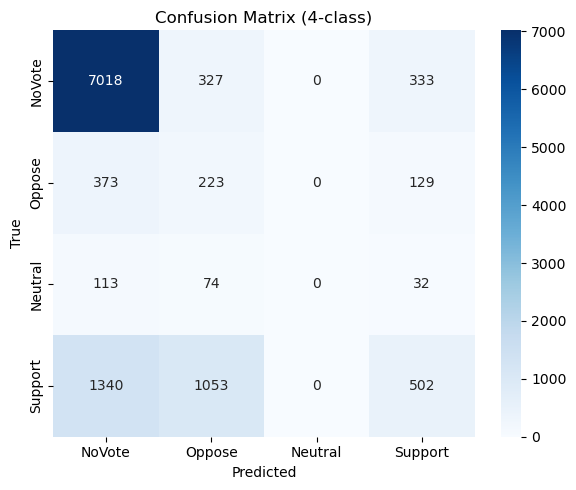

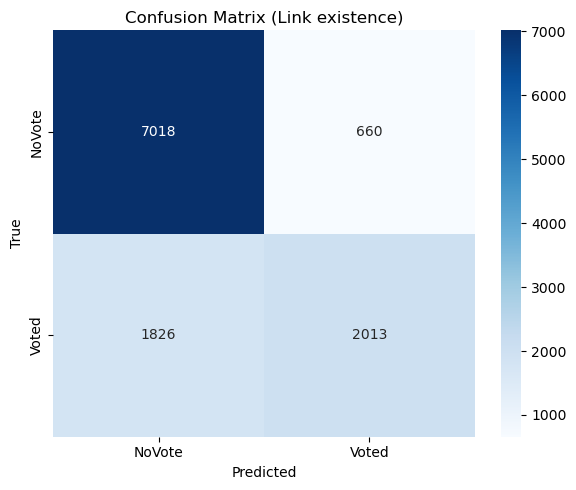

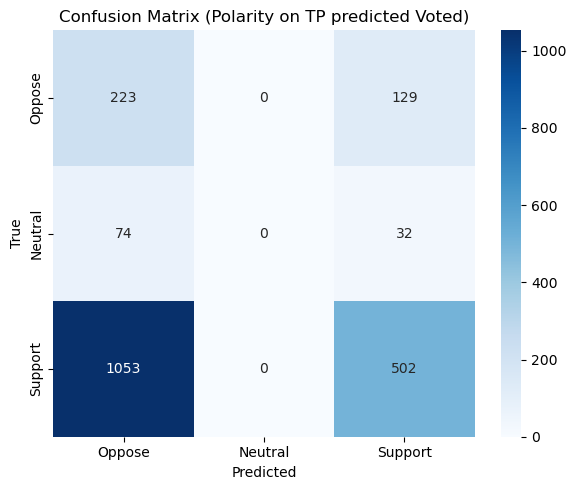

In [16]:
def plot_cm(cm, labels, title, normalize=False):
    if normalize:
        cm_plot = cm.astype(float)
        cm_plot = cm_plot / cm_plot.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        cm_plot = cm.astype(int)   # <-- qui int
        fmt = "d"

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_plot, annot=True, fmt=fmt, cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- 1) 4-class confusion matrix ----
labels_4 = ["NoVote", "Oppose", "Neutral", "Support"]
cm4 = confusion_matrix(y_true_4, y_pred_4, labels=[0,1,2,3])
plot_cm(cm4, labels_4, "Confusion Matrix (4-class)", normalize=False)
# plot_cm(cm4, labels_4, "Confusion Matrix (4-class) - normalized", normalize=True)

# ---- 2) Link existence confusion matrix (NoVote vs Voted) ----
y_true_link = (y_true_4 != 0).astype(int)
y_pred_link = (y_pred_4 != 0).astype(int)
cm_link = confusion_matrix(y_true_link, y_pred_link, labels=[0,1])
plot_cm(cm_link, ["NoVote", "Voted"], "Confusion Matrix (Link existence)", normalize=False)
# plot_cm(cm_link, ["NoVote", "Voted"], "Confusion Matrix (Link existence) - normalized", normalize=True)

# ---- 3) Polarity confusion matrix on TP edges where model predicts Voted ----
mask_tp = (y_true_4 != 0) & (y_pred_4 != 0)
y_true_pol = (y_true_4[mask_tp] - 1)  # {0,1,2}
y_pred_pol = (y_pred_4[mask_tp] - 1)  # {0,1,2}
cm_pol = confusion_matrix(y_true_pol, y_pred_pol, labels=[0,1,2])
plot_cm(cm_pol, ["Oppose", "Neutral", "Support"],
        "Confusion Matrix (Polarity on TP predicted Voted)", normalize=False)
# plot_cm(cm_pol, ["Oppose", "Neutral", "Support"],
#         "Confusion Matrix (Polarity on TP predicted Voted) - normalized", normalize=True)